In [1]:
import os
os.chdir("../../../../")

In [2]:
import matplotlib.pyplot as plt
from utilities import plot,errors
import pandas as pd
from utilities.recalibration import *
from sklearn.isotonic import IsotonicRegression
import jax
import jax.numpy as jnp

In [3]:
training_predictions_df=pd.read_csv("/home/interns/Hetvi/NILM_Uncertainty/notebooks/dishwasher/s2p/mlp/training_predictions.csv")
testing_predictions_df = pd.read_csv("/home/interns/Hetvi/NILM_Uncertainty/notebooks/dishwasher/s2p/mlp/testing_predictions.csv")
cal_predictions_df= pd.read_csv("/home/interns/Hetvi/NILM_Uncertainty/notebooks/dishwasher/s2p/mlp/calibration_predictions.csv")

In [4]:
y_train=training_predictions_df['Ground Truth']
mc_train_mean=training_predictions_df['MC_mean']
mc_train_sigma=training_predictions_df['MC_sigma']
de_train_mean=training_predictions_df['DE_mean']
de_train_sigma=training_predictions_df['DE_sigma']
bs_train_mean=training_predictions_df['BS_mean']
bs_train_sigma=training_predictions_df['BS_sigma']

y_cal=cal_predictions_df['Ground Truth']
mc_cal_mean=cal_predictions_df['MC_Mean']
mc_cal_sigma=cal_predictions_df['MC_Sigma']
de_cal_mean=cal_predictions_df['DE_mean']
de_cal_sigma=cal_predictions_df['DE_sigma']
bs_cal_mean=cal_predictions_df['bs_Mean']
bs_cal_sigma=cal_predictions_df['bs_Sigma']

y_test=testing_predictions_df['Ground Truth']
mc_test_mean=testing_predictions_df['MC_Mean']
mc_test_sigma=testing_predictions_df['MC_Sigma'] 
de_test_mean=testing_predictions_df['de_Mean']
de_test_sigma=testing_predictions_df['de_Sigma']
bs_test_mean=testing_predictions_df['bs_Mean']
bs_test_sigma=testing_predictions_df['bs_Sigma']

In [5]:
def ace(ideal,predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss,in_axes=(0,0))(ideal,predicted))
    # return(jnp.sum(jnp.abs(dataframe['Ideal'].values-dataframe['Counts'].values)))


In [6]:
# For saving
recalibration_df = pd.DataFrame()

## MC Dropout

In [7]:
series_train = find_p_hat(y_train,mc_train_mean,mc_train_sigma)
series_test = find_p_hat(y_test,mc_test_mean,mc_test_sigma)
series_cal= find_p_hat(y_cal,mc_cal_mean,mc_cal_sigma)
p=series_cal.index
recalibration_df["p"] = p

In [8]:
calibrator_mc = IsotonicRegression(out_of_bounds='clip')
calibrator_mc.fit(series_cal.values,series_cal.index)
new_p=calibrator_mc.predict(series_cal.index)

In [9]:
new_p_hat_train=find_new_p_hat(y_train,new_p,mc_train_mean,mc_train_sigma)
new_p_hat_cal=find_new_p_hat(y_cal,new_p,mc_cal_mean,mc_cal_sigma)
new_p_hat_test=find_new_p_hat(y_test,new_p,mc_test_mean,mc_test_sigma)

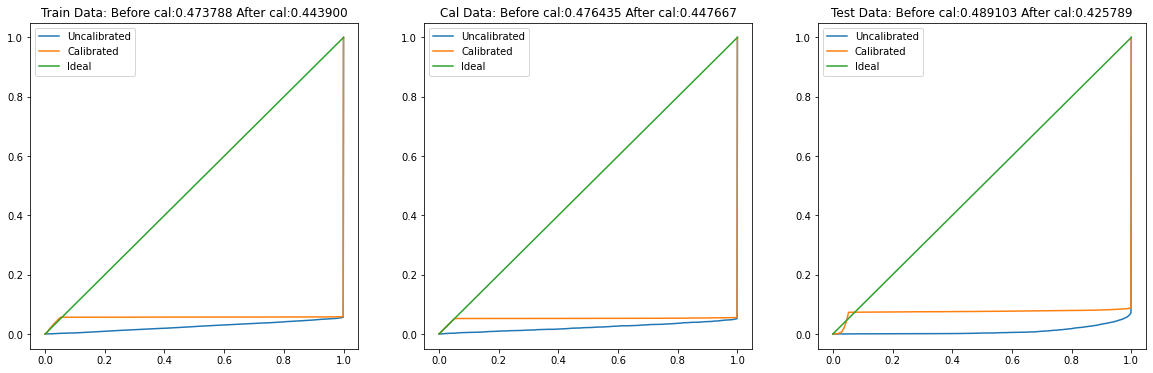

In [10]:

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(p, series_train.values, label='Uncalibrated')
plt.plot(p, new_p_hat_train, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1,3,2)
plt.plot(p, series_cal.values, label='Uncalibrated')
plt.plot(p, new_p_hat_cal, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1,3,3)
plt.plot(p, series_test.values, label='Uncalibrated')
plt.plot(p, new_p_hat_test, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()

In [11]:
recalibration_df["phat_mc"] = series_test.values
recalibration_df["new_p_mc"] = new_p
recalibration_df["new_phat_mc"] = new_p_hat_test

## Deep Ensemble

In [12]:
series_train = find_p_hat(y_train,de_train_mean,de_train_sigma)
series_test = find_p_hat(y_test,de_test_mean,de_test_sigma)
series_cal= find_p_hat(y_cal,de_cal_mean,de_cal_sigma)

In [13]:
calibrator_de = IsotonicRegression(out_of_bounds='clip')
calibrator_de.fit(series_cal.values,series_cal.index)
new_p=calibrator_de.predict(series_cal.index)


In [14]:
new_p_hat_train=find_new_p_hat(y_train,new_p,de_train_mean,de_train_sigma)
new_p_hat_cal=find_new_p_hat(y_cal,new_p,de_cal_mean,de_cal_sigma)
new_p_hat_test=find_new_p_hat(y_test,new_p,de_test_mean,de_test_sigma)

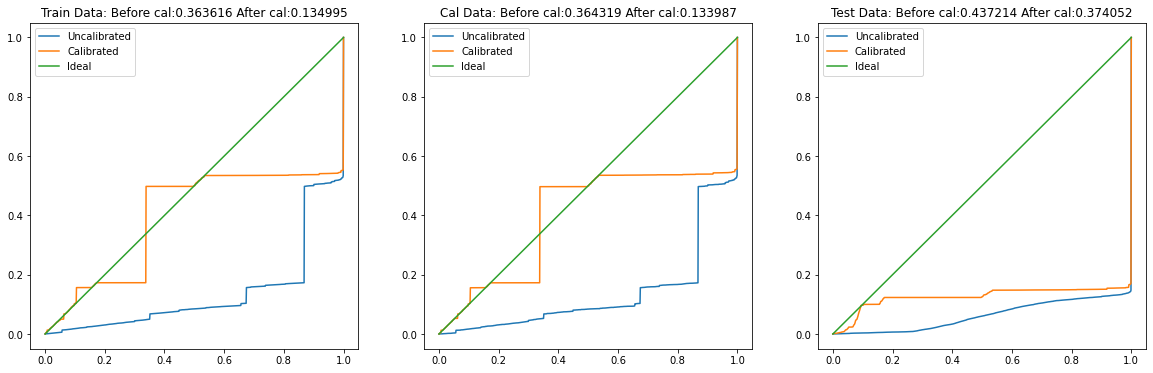

In [15]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(p, series_train.values, label='Uncalibrated')
plt.plot(p, new_p_hat_train, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1,3,2)
plt.plot(p, series_cal.values, label='Uncalibrated')
plt.plot(p, new_p_hat_cal, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1,3,3)
plt.plot(p, series_test.values, label='Uncalibrated')
plt.plot(p, new_p_hat_test, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()

In [16]:
recalibration_df["phat_de"] = series_test.values
recalibration_df["new_p_de"] = new_p
recalibration_df["new_phat_de"] = new_p_hat_test

## Bootstrap

In [17]:
series_train = find_p_hat(y_train,bs_train_mean,bs_train_sigma)
series_test = find_p_hat(y_test,bs_test_mean,bs_test_sigma)
series_cal= find_p_hat(y_cal,bs_cal_mean,bs_cal_sigma)

In [18]:
calibrator_bs = IsotonicRegression(out_of_bounds='clip')
calibrator_bs.fit(series_cal.values,series_cal.index)
new_p=calibrator_bs.predict(series_cal.index)


In [19]:
new_p_hat_train=find_new_p_hat(y_train,new_p,bs_train_mean,bs_train_sigma)
new_p_hat_cal=find_new_p_hat(y_cal,new_p,bs_cal_mean,bs_cal_sigma)
new_p_hat_test=find_new_p_hat(y_test,new_p,bs_test_mean,bs_test_sigma)

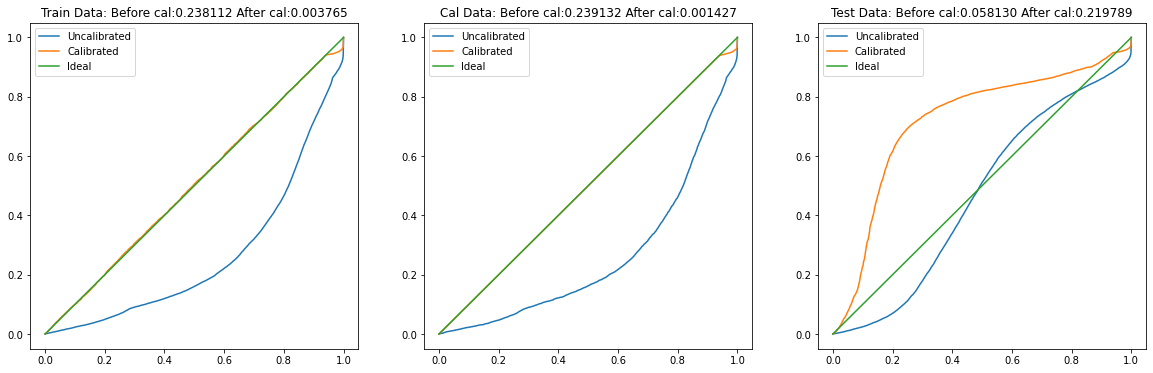

In [20]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(p, series_train.values, label='Uncalibrated')
plt.plot(p, new_p_hat_train, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1,3,2)
plt.plot(p, series_cal.values, label='Uncalibrated')
plt.plot(p, new_p_hat_cal, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1,3,3)
plt.plot(p, series_test.values, label='Uncalibrated')
plt.plot(p, new_p_hat_test, label='Calibrated')
plt.plot([0, 1], [0, 1], label="Ideal")
plt.title(f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()

In [21]:
recalibration_df["phat_bs"] = series_test.values
recalibration_df["new_p_bs"] = new_p
recalibration_df["new_phat_bs"] = new_p_hat_test


In [22]:
recalibration_df.to_csv("notebooks/dishwasher/s2p/mlp/recalibration_df.csv",index=False)